## How do I prep my data for analysis?

The taxis dataset is ideal for learning how to clean and prep data, because it has many different types of data and it is so messy. The whole idea of preparing your data is to ensure:

- there are no missing values
- the date / number / location entries are in the correct formats
- values are normalized if needed
- correlated values are dealt with (e.g., by using PCA)
- text values are encoded as needed
- data is aggregated / disaggregated as needed
- feature names are what you require
- distributions of quantitative data are what you expect
- etc.

There are many things to look for. It is tedious, and one of the least liked tasks by most. Unfortunately, it is also both one of the most important tasks, and one of the most time consuming.

In [1]:
# First, import some libraries, specify file location, and import data
# Use "warnings" to cut down on the verbosity of warnings
import warnings 
warnings.filterwarnings('ignore')
import seaborn as sns
import pandas as pd

In [2]:
df = sns.load_dataset('taxis')
df.head()

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,Hudson Sq,Yorkville West,Manhattan,Manhattan
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,Midtown East,Yorkville West,Manhattan,Manhattan


There are several ways we can look at the data, using things like 'columns', 'info', 'shape' etc.

In [3]:
df.columns

Index(['pickup', 'dropoff', 'passengers', 'distance', 'fare', 'tip', 'tolls',
       'total', 'color', 'payment', 'pickup_zone', 'dropoff_zone',
       'pickup_borough', 'dropoff_borough'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6433 entries, 0 to 6432
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pickup           6433 non-null   object 
 1   dropoff          6433 non-null   object 
 2   passengers       6433 non-null   int64  
 3   distance         6433 non-null   float64
 4   fare             6433 non-null   float64
 5   tip              6433 non-null   float64
 6   tolls            6433 non-null   float64
 7   total            6433 non-null   float64
 8   color            6433 non-null   object 
 9   payment          6389 non-null   object 
 10  pickup_zone      6407 non-null   object 
 11  dropoff_zone     6388 non-null   object 
 12  pickup_borough   6407 non-null   object 
 13  dropoff_borough  6388 non-null   object 
dtypes: float64(5), int64(1), object(8)
memory usage: 703.7+ KB


In [5]:
df.shape

(6433, 14)

In [6]:
df.describe()

,passengers,distance,fare,tip,tolls,total
count,6433.000000,6433.000000,6433.000000,6433.00000,6433.000000,6433.000000
mean,1.539251,3.024617,13.091073,1.97922,0.325273,18.517794
std,1.203768,3.827867,11.551804,2.44856,1.415267,13.815570
min,0.000000,0.000000,1.000000,0.00000,0.000000,1.300000
25%,1.000000,0.980000,6.500000,0.00000,0.000000,10.800000
50%,1.000000,1.640000,9.500000,1.70000,0.000000,14.160000
75%,2.000000,3.210000,15.000000,2.80000,0.000000,20.300000
max,6.000000,36.700000,150.000000,33.20000,24.020000,174.820000


With this next block of code, we are filtering and aggregating data, then printing out the shape of the new dataframes. Shape is always (rows , columns).

In [7]:
# Filter to only observations where passengers are greater than or equal to 2
df1=df[df['passengers']>=2]
print(f"The rows and columns for df1 are {df1.shape}")

# Group the data in the total column by pickup borough, then dropoff borough
df2=pd.DataFrame(df1.groupby(['pickup_borough','dropoff_borough'])['total'] .agg(sum))
df2.reset_index()
print(f"The rows and columns for df2 are {df2.shape}")

# Bucket the total column into equal size buckets (useful for things like histograms)
df3 = pd.DataFrame (pd.qcut( df1['total'],3,labels=None ).value_counts())
print(f"The rows and columns of df3 are {df3.shape}")

The rows and columns for df1 are (1659, 14)
The rows and columns for df2 are (14, 1)
The rows and columns of df3 are (3, 1)


Back to the original dataframe, we now want to start addressing null values. After each thing we do, we'll print out the current list of nulls.

In [8]:
nulls = df.isnull().sum()
print("These are the features with null values, and the count of null values in each.")
print(nulls[nulls >= 1])

These are the features with null values, and the count of null values in each.
payment            44
pickup_zone        26
dropoff_zone       45
pickup_borough     26
dropoff_borough    45
dtype: int64


Since locations are very important to us, any row that is missing location information is of no use. What are the counts for boroughs and zones?

In [9]:
print("Number of pickup boroughs:", len(df['pickup_borough'].unique()))
print("Number of pickup zones:", len(df['pickup_zone'].unique()))

Number of pickup boroughs: 5
Number of pickup zones: 195


We have a lot more zones than boroughs, safe to say zones are nested in boroughs. 
Question: if the row is missing borough, will it also be missing zone?

In [10]:
# First we create dataframes with no missing pickup and dropoff boroughs. 
# These dataframes also have the pickup/dropoff zone columns too.

df_not_null_puzone = df[df['pickup_borough'].notnull()]
df_not_null_dozone = df[df['dropoff_borough'].notnull()]

# Next, we count how many missing pickup and dropoff zones there are. 
# Remember, this result has already been filtered for missing boroughs.

print(df_not_null_puzone['pickup_zone'].isnull().sum())
print(df_not_null_dozone['dropoff_zone'].isnull().sum())

0
0


Looks like when we took out all observations with missing boroughs, we also removed all values with missing zones. Good. This means we can drop observations that are missing both pickup and dropoff boroughs and zones, because there's no way to infer these.
Next, we want to know how many observations with missing zones and boroughs are left.

In [11]:
df2 = df[df['pickup_borough'].notnull() | df['dropoff_borough'].notnull()]
nulls2 = df2.isnull().sum()
print(nulls2[nulls2 >= 1])

payment            44
pickup_zone         5
dropoff_zone       24
pickup_borough      5
dropoff_borough    24
dtype: int64


Originally, we had 26 missing pickup boroughs and 45 missing dropoff boroughs, now we're down to 5 and 24 respectively. We can still use this info for studying data on either pickup or dropoff locations, but if we want to study data on entire trips (having both pickup and dropoff info) then we'll want to filter out any observations that are missing either pickup or dropoff info.

Next is payment type. We want to figure out the percentage of cash vs. credit payments overall, and by locations. But, we did have quite a few missing values in payment type, which we need to deal with. Let's first look at the class balance overall, then by pickup and dropoff boroughs.

In [12]:
df2_notnull = df2[df2['payment'].notnull()]

print('Balance of payment feature overall')
print(df2_notnull['payment'].value_counts(normalize = True).to_frame())
print ("")

print('Balance of payment feature by pickup borough')
print(df2_notnull.groupby('pickup_borough')['payment'].value_counts(normalize = True).to_frame())
print ("")

print('Balance of payment feature by dropoff borough')
print(df2_notnull.groupby('dropoff_borough')['payment'].value_counts(normalize = True).to_frame())

Balance of payment feature overall
             payment
credit card  0.71608
cash         0.28392

Balance of payment feature by pickup borough
                             payment
pickup_borough payment              
Bronx          credit card  0.747475
               cash         0.252525
Brooklyn       credit card  0.686842
               cash         0.313158
Manhattan      credit card  0.733193
               cash         0.266807
Queens         credit card  0.590139
               cash         0.409861

Balance of payment feature by dropoff borough
                              payment
dropoff_borough payment              
Bronx           credit card  0.617647
                cash         0.382353
Brooklyn        credit card  0.692153
                cash         0.307847
Manhattan       credit card  0.737056
                cash         0.262944
Queens          credit card  0.569288
                cash         0.430712
Staten Island   credit card  1.000000


We can see that overall the split is about 70/30, but not nearly so in some locations. Best thing would be to calculate the current class balance in each location, then impute values based on that. So, if a location had about 70% credit and 30% cash, we would want to fill in the missing values with roughly that same balance.

Question though: do we use pickup or dropoff borough? Here's where we now decide we want to do things by total trip, so we first need to create a dataframe with no null values in either pickup or dropoff borough.

In [13]:
df3 = df2[(df2['pickup_borough'].notnull()) & (df2['dropoff_borough'].notnull())]
nulls = df3.isnull().sum()
print(nulls)

pickup              0
dropoff             0
passengers          0
distance            0
fare                0
tip                 0
tolls               0
total               0
color               0
payment            42
pickup_zone         0
dropoff_zone        0
pickup_borough      0
dropoff_borough     0
dtype: int64


Once we get rid of the rows with missing location, the only missing values we have now are for payment. We can see from above that we have 42 of them. Below, we look at the overall percentage split again between cash and credit.

In [14]:
df3_wasNull = df3
print(df3_wasNull['payment'].value_counts(normalize=True))
nulls1 = df3_wasNull.isnull().sum()

credit card    0.716922
cash           0.283078
Name: payment, dtype: float64


OK, now let's assign values to the missing ones based on the cash/credit split for each trip type. We group by trip (both pickup and dropoff borough). Then, for each pickup/dropoff pair, we assign values based on the split for that trip type. Finally, we check to make sure our cash/credit split overall has not been affected.

In [15]:
import numpy as np
for _, gdf in df3.groupby(['pickup_borough', 'dropoff_borough'])['payment']:
    vc = gdf.value_counts(normalize=True)
    df3.loc[gdf.loc[gdf.isna()].index, 'payment'] = (
        np.random.choice(vc.index, gdf.isna().sum(), p=vc)
    )
print(df3['payment'].value_counts(normalize=True).to_frame())

              payment
credit card  0.716278
cash         0.283722


Looks good. We were able to impute and assign values for cash/credit based on the split by total trip from/to locations, and maintain our overall class balance across the whole dataset.

Just a final check to make sure that all nulls have been taken care of now.

In [16]:
df3.isnull().sum()

pickup             0
dropoff            0
passengers         0
distance           0
fare               0
tip                0
tolls              0
total              0
color              0
payment            0
pickup_zone        0
dropoff_zone       0
pickup_borough     0
dropoff_borough    0
dtype: int64

Yes, all done. Now, we need to look at other aspects of the dataset. In particular, the summary statistics.

In [17]:
df3.describe()

,passengers,distance,fare,tip,tolls,total
count,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000
mean,1.540812,2.994479,12.873472,1.959723,0.314526,18.281059
std,1.205929,3.717136,10.718949,2.359509,1.368289,12.947807
min,0.000000,0.000000,1.000000,0.000000,0.000000,1.300000
25%,1.000000,0.990000,6.500000,0.000000,0.000000,10.800000
50%,1.000000,1.650000,9.500000,1.700000,0.000000,14.160000
75%,2.000000,3.200000,15.000000,2.790000,0.000000,20.300000
max,6.000000,36.700000,150.000000,23.190000,24.020000,174.820000


In [18]:
#There are apparently trips with zero passengers that went zero distance. Let's take a look at those.
print("The number of rows and columns in a dataset filtered on zero passengers is:")
df3[df3['passengers'] == 0].shape

The number of rows and columns in a dataset filtered on zero passengers is:


(96, 14)

Wow, 96 rows are missing passengers. We need to decide what to do, but not right now. Next, let's look at numbers of rows and columns in a dataset filtered on zero distance. Really, you don't need to know the number of columns for this, I just used shape as an example of one way to get this info.

In [19]:
#Holy cow, 96 rows are missing number of passengers. Is there a chance maybe they are delivering food?
#Let's wait on that decision for now. How about the trips with zero distance?
df3[df3['distance'] == 0].shape

(36, 14)

Fewer trips with zero distance, and this is an easy fix. We have pickup and dropoff location, so we can impute the values based on other trips with the same from/to locations. In order to do a good job of this, we want to get more granular with the location, so we will use zone instead of borough. 

In [20]:
df3_zeroDist = df3[df3['distance'] == 0]
df3_zeroDist.groupby(['pickup_zone', 'dropoff_zone'])['distance'].value_counts()

pickup_zone                     dropoff_zone                    distance
Astoria                         Astoria                         0.0         2
Bushwick South                  Bushwick South                  0.0         1
Clinton East                    Clinton East                    0.0         1
Cobble Hill                     Cobble Hill                     0.0         1
Downtown Brooklyn/MetroTech     Downtown Brooklyn/MetroTech     0.0         1
Dyker Heights                   Dyker Heights                   0.0         1
East Chelsea                    East Chelsea                    0.0         1
Financial District North        World Trade Center              0.0         1
Flatbush/Ditmas Park            Flatbush/Ditmas Park            0.0         1
Fort Greene                     Fort Greene                     0.0         1
Garment District                Garment District                0.0         1
Hudson Sq                       Hudson Sq                       0.0  

Biggest issue here is that we have very few duplicate trips with zero distance, so we really have nothing to impute from. We should just drop those observations in this case. 

In [21]:
df4 = df3[(df3['distance'] != 0) & (df3['passengers'] != 0)]
df4.head()

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,Hudson Sq,Yorkville West,Manhattan,Manhattan
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,Midtown East,Yorkville West,Manhattan,Manhattan


Now, let's break out the year, month, day, and hour into separate columns so we can do other kinds of analysis related to time.

In [22]:
import datetime as dt
from datetime import date

df4['pickup'] = pd.to_datetime(df4['pickup'], format = '%Y-%m-%d %H:%M:%S')
df4['Pday'] = df4['pickup'].dt.weekday
df4['Pmonth'] = df4['pickup'].dt.month
df4['Pyear'] = df4['pickup'].dt.year
df4['Phour'] = df4['pickup'].dt.hour
df4['dropoff'] = pd.to_datetime(df4['dropoff'], format = '%Y-%m-%d %H:%M:%S')
df4['Dday'] = df4['dropoff'].dt.weekday
df4['Dmonth'] = df4['dropoff'].dt.month
df4['Dyear'] = df4['dropoff'].dt.year
df4['Dhour'] = df4['dropoff'].dt.hour
df4.drop(['pickup', 'dropoff'], inplace = True, axis = 1)

list(df4.columns)
#df4.head()

['passengers',
 'distance',
 'fare',
 'tip',
 'tolls',
 'total',
 'color',
 'payment',
 'pickup_zone',
 'dropoff_zone',
 'pickup_borough',
 'dropoff_borough',
 'Pday',
 'Pmonth',
 'Pyear',
 'Phour',
 'Dday',
 'Dmonth',
 'Dyear',
 'Dhour']

Quick final look at summary stats to make sure everything looks good.

In [23]:
df4.describe()

,passengers,distance,fare,tip,tolls,total,Pday,Pmonth,Pyear,Phour,Dday,Dmonth,Dyear,Dhour
count,6252.000000,6252.000000,6252.000000,6252.000000,6252.000000,6252.000000,6252.000000,6252.000000,6252.0,6252.000000,6252.000000,6252.000000,6252.0,6252.000000
mean,1.566219,3.011766,12.875187,1.956750,0.309623,18.279819,3.164427,2.999840,2019.0,13.881638,3.166827,3.000000,2019.0,13.921465
std,1.201209,3.722938,10.656627,2.346348,1.358912,12.853383,1.912791,0.012647,0.0,6.068853,1.915300,0.017887,0.0,6.144561
min,1.000000,0.010000,1.000000,0.000000,0.000000,1.300000,0.000000,2.000000,2019.0,0.000000,0.000000,2.000000,2019.0,0.000000
25%,1.000000,1.000000,6.500000,0.000000,0.000000,10.800000,2.000000,3.000000,2019.0,10.000000,2.000000,3.000000,2019.0,10.000000
50%,1.000000,1.660000,9.500000,1.700000,0.000000,14.160000,3.000000,3.000000,2019.0,15.000000,3.000000,3.000000,2019.0,15.000000
75%,2.000000,3.220000,15.000000,2.760000,0.000000,20.300000,5.000000,3.000000,2019.0,19.000000,5.000000,3.000000,2019.0,19.000000
max,6.000000,36.700000,150.000000,23.190000,24.020000,174.820000,6.000000,3.000000,2019.0,23.000000,6.000000,4.000000,2019.0,23.000000


Our new summary stats include our new columns of year, month, day, and hour. A couple questions: the max dropoff month is 4, but the max pickup month is 3. Entirely possible if, let's say, the person was picked up at 11:59 pm March 31 and dropped off 12:00 am on April 1st. 

Another thing to note: we are only working with about two months of data here, so analysis on month is probably not useful. 

Let's take a look at the distribution of the data, to see if it is normal or skewed. We need to know for a variety of reasons.

''

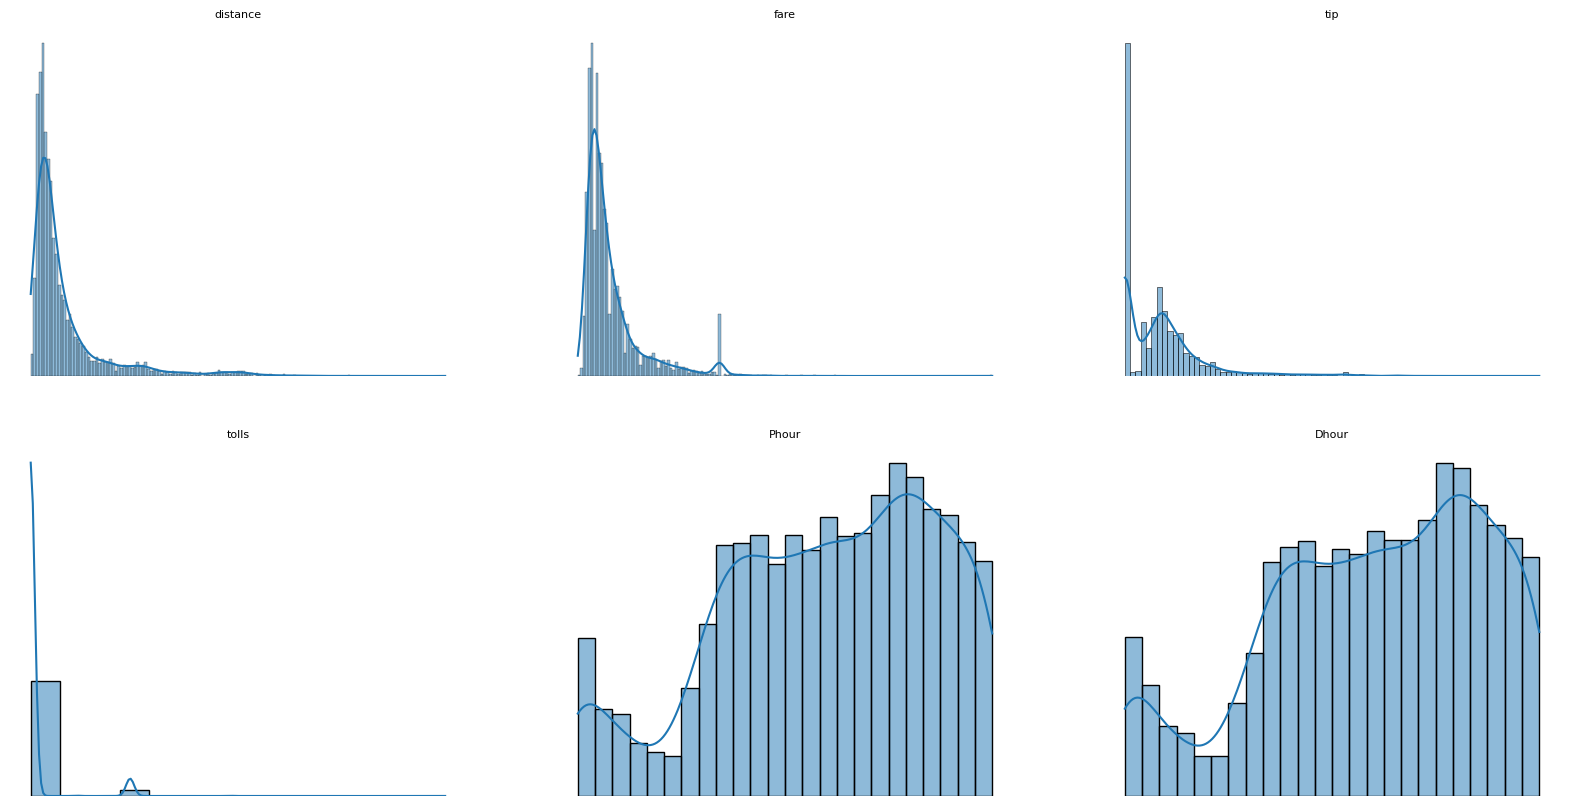

In [24]:
from matplotlib import pyplot as plt

f = plt.figure(figsize=(20,10))
f.tight_layout()

# Subplot 1
plt.subplot(2, 3, 1)
feature = 'distance'
hist = sns.histplot(data=df4, x=feature, label=feature, kde=True)
plt.title(feature, fontsize=8)
plt.axis('off')

# Subplot 2
plt.subplot(2, 3, 2)
feature = 'fare'
hist = sns.histplot(data=df4, x=feature, label=feature, kde=True)
plt.title(feature, fontsize=8)
plt.axis('off')

# Subplot 3
plt.subplot(2, 3, 3)
feature = 'tip'
hist = sns.histplot(data=df4, x=feature, label=feature, kde=True)
plt.title(feature, fontsize=8)
plt.axis('off')

# Subplot 4
plt.subplot(2, 3, 4)
feature = 'tolls'
hist = sns.histplot(data=df4, x=feature, label=feature, kde=True)
plt.title(feature, fontsize=8)
plt.axis('off')

# Subplot 5
plt.subplot(2, 3, 5)
feature = 'Phour'
hist = sns.histplot(data=df4, x=feature, label=feature, kde=True)
plt.title(feature, fontsize=8)
plt.axis('off')

# Subplot 6
plt.subplot(2, 3, 6)
feature = 'Dhour'
hist = sns.histplot(data=df4, x=feature, label=feature, kde=True)
plt.title(feature, fontsize=8)
plt.axis('off')
;


As we step through the histograms above, most of the features are not normally distributed. Due to that, and the fact that we're comparing features with different scales, we would benefit from normalizing the data in the columns. We will do that towards the end of this notebook. First, let's concatenate pickup and dropoff boroughs so each observation belongs to a full trip.

In [25]:
df4['trip'] = df4['pickup_borough'] + df4['dropoff_borough']
df4.head()

,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,...,dropoff_borough,Pday,Pmonth,Pyear,Phour,Dday,Dmonth,Dyear,Dhour,trip
0,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,...,Manhattan,5,3,2019,20,5,3,2019,20,ManhattanManhattan
1,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,...,Manhattan,0,3,2019,16,0,3,2019,16,ManhattanManhattan
2,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,...,Manhattan,2,3,2019,17,2,3,2019,18,ManhattanManhattan
3,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,Hudson Sq,Yorkville West,...,Manhattan,6,3,2019,1,6,3,2019,1,ManhattanManhattan
4,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,Midtown East,Yorkville West,...,Manhattan,5,3,2019,13,5,3,2019,13,ManhattanManhattan


Final step here: we convert the rest of the categorical columns to numbers to make them machine readable. We won't bother to do this for zones, since there are so many zones.

In [26]:
from sklearn.preprocessing import OneHotEncoder 
cat_encoder = OneHotEncoder() 
df4_hot = cat_encoder.fit_transform(df4[['color', 'payment', 'trip', 'pickup_borough', 'dropoff_borough']]) 
enc_names = cat_encoder.get_feature_names_out()
df4_hotdf = pd.DataFrame(df4_hot.todense(), columns = enc_names)
df4_tr = pd.merge(df4_hotdf, df4.drop(['color', 'payment', 'pickup_borough', 'dropoff_borough', 'pickup_zone', 'dropoff_zone', 'trip'], axis=1), left_index=True, right_index=True)
df4_tr.drop(['payment_cash', 'color_green'], inplace = True, axis = 1)

df4_tr.columns

,color_yellow,payment_credit card,trip_BronxBronx,trip_BronxBrooklyn,trip_BronxManhattan,trip_BronxQueens,trip_BrooklynBronx,trip_BrooklynBrooklyn,trip_BrooklynManhattan,trip_BrooklynQueens,...,tolls,total,Pday,Pmonth,Pyear,Phour,Dday,Dmonth,Dyear,Dhour
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,12.95,5,3,2019,20,5,3,2019,20
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.30,0,3,2019,16,0,3,2019,16
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,14.16,2,3,2019,17,2,3,2019,18
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,36.95,6,3,2019,1,6,3,2019,1
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,13.40,5,3,2019,13,5,3,2019,13


What columns are we left with?

In [27]:
df4_tr.columns

Index(['color_yellow', 'payment_credit card', 'trip_BronxBronx',
       'trip_BronxBrooklyn', 'trip_BronxManhattan', 'trip_BronxQueens',
       'trip_BrooklynBronx', 'trip_BrooklynBrooklyn', 'trip_BrooklynManhattan',
       'trip_BrooklynQueens', 'trip_ManhattanBronx', 'trip_ManhattanBrooklyn',
       'trip_ManhattanManhattan', 'trip_ManhattanQueens',
       'trip_ManhattanStaten Island', 'trip_QueensBronx',
       'trip_QueensBrooklyn', 'trip_QueensManhattan', 'trip_QueensQueens',
       'pickup_borough_Bronx', 'pickup_borough_Brooklyn',
       'pickup_borough_Manhattan', 'pickup_borough_Queens',
       'dropoff_borough_Bronx', 'dropoff_borough_Brooklyn',
       'dropoff_borough_Manhattan', 'dropoff_borough_Queens',
       'dropoff_borough_Staten Island', 'passengers', 'distance', 'fare',
       'tip', 'tolls', 'total', 'Pday', 'Pmonth', 'Pyear', 'Phour', 'Dday',
       'Dmonth', 'Dyear', 'Dhour'],
      dtype='object')

Since our data is only from a couple months and one year, might as well drop month and year completely. In addition, we'll get rid of dropoff hour because it is correlated with, and less important than, pickup hour.

In [28]:
df4_tr.drop(['Pmonth', 'Pyear', 'Dday', 'Dmonth', 'Dyear', 'Dhour'], inplace=True, axis=1)
df4_tr.columns

Index(['color_yellow', 'payment_credit card', 'trip_BronxBronx',
       'trip_BronxBrooklyn', 'trip_BronxManhattan', 'trip_BronxQueens',
       'trip_BrooklynBronx', 'trip_BrooklynBrooklyn', 'trip_BrooklynManhattan',
       'trip_BrooklynQueens', 'trip_ManhattanBronx', 'trip_ManhattanBrooklyn',
       'trip_ManhattanManhattan', 'trip_ManhattanQueens',
       'trip_ManhattanStaten Island', 'trip_QueensBronx',
       'trip_QueensBrooklyn', 'trip_QueensManhattan', 'trip_QueensQueens',
       'pickup_borough_Bronx', 'pickup_borough_Brooklyn',
       'pickup_borough_Manhattan', 'pickup_borough_Queens',
       'dropoff_borough_Bronx', 'dropoff_borough_Brooklyn',
       'dropoff_borough_Manhattan', 'dropoff_borough_Queens',
       'dropoff_borough_Staten Island', 'passengers', 'distance', 'fare',
       'tip', 'tolls', 'total', 'Pday', 'Phour'],
      dtype='object')

In [29]:
df4_tr.columns = ['c_yellow', 'p_credit', 't_BronBron', 't_BronBroo', 't_BronManh', 't_BronQuee', 't_BrooBron', 't_BrooBroo', 't_BrooManh', 
    't_BrooQuee', 't_ManhBron', 't_ManhBroo', 't_ManhManh', 't_ManhQuee', 't_ManhStat', 't_QueeBron', 't_QueeBroo', 't_QueeManh', 't_QueeQuee',
    'p_Bron', 'p_Broo', 'p_Manh', 'p_Quee', 'd_Bron', 'd_Broo', 'd_Manh', 'd_Quee', 'd_Stat',
    'pass', 'dist', 'fare', 'tip', 'tolls', 'total', 'p_day', 'p_hour']
df4_tr.columns

Index(['c_yellow', 'p_credit', 't_BronBron', 't_BronBroo', 't_BronManh',
       't_BronQuee', 't_BrooBron', 't_BrooBroo', 't_BrooManh', 't_BrooQuee',
       't_ManhBron', 't_ManhBroo', 't_ManhManh', 't_ManhQuee', 't_ManhStat',
       't_QueeBron', 't_QueeBroo', 't_QueeManh', 't_QueeQuee', 'p_Bron',
       'p_Broo', 'p_Manh', 'p_Quee', 'd_Bron', 'd_Broo', 'd_Manh', 'd_Quee',
       'd_Stat', 'pass', 'dist', 'fare', 'tip', 'tolls', 'total', 'p_day',
       'p_hour'],
      dtype='object')

In [30]:
#OK, remember that most features in our dataset were skewed. Scaling helps with that. 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df4_norm = scaler.fit_transform(df4_tr)
norm_names = scaler.get_feature_names_out()
df4_normdf = pd.DataFrame(df4_norm, columns = norm_names)
df4_normdf.head()

,c_yellow,p_credit,t_BronBron,t_BronBroo,t_BronManh,t_BronQuee,t_BrooBron,t_BrooBroo,t_BrooManh,t_BrooQuee,...,d_Quee,d_Stat,pass,dist,fare,tip,tolls,total,p_day,p_hour
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.043336,0.040268,0.092712,0.0,0.067139,0.833333,0.869565
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.021259,0.026846,0.000000,0.0,0.046104,0.000000,0.695652
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.037067,0.043624,0.101768,0.0,0.074112,0.333333,0.739130
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.209594,0.174497,0.265201,0.0,0.205452,1.000000,0.043478
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.4,0.058599,0.053691,0.047434,0.0,0.069733,0.833333,0.565217


Finally, we'll go ahead and save this dataset, since we worked so hard to create it.

In [1]:
df4.to_csv("categories_output.csv")
df4_normdf.to_csv("encoded_output.csv") 

NameError: name 'df4' is not defined